# Gridded NetCDF modelresults

2D modelresults stored in NetCDF or Grib can be loaded to ModelSkill using xarray. In this way, MIKE 21 modelresults in dfsu format can easily be compared to model results from third party providers often stored in NetCDF. 

In [1]:
import xarray as xr
import modelskill as ms

## Observations

In [2]:
o1 = ms.PointObservation('../tests/testdata/SW/HKNA_Hm0.dfs0', item=0, x=4.2420, y=52.6887, name="HKNA")
o2 = ms.PointObservation("../tests/testdata/SW/eur_Hm0.dfs0", item=0, x=3.2760, y=51.9990, name="EPL")
o3 = ms.TrackObservation("../tests/testdata/SW/Alti_c2_Dutch.dfs0", item=3, name="c2")

## MIKE ModelResult

In [3]:
mrMIKE = ms.model_result('../tests/testdata/SW/HKZN_local_2017_DutchCoast.dfsu', name='MIKE21SW', item=0)

## NetCDF ModelResult

In [4]:
fn = "../tests/testdata/SW/ERA5_DutchCoast.nc"
xr.open_dataset(fn)

<xarray.Dataset>
Dimensions:    (longitude: 20, latitude: 11, time: 67)
Coordinates:
  * longitude  (longitude) float32 -1.0 -0.5 0.0 0.5 1.0 ... 6.5 7.0 7.5 8.0 8.5
  * latitude   (latitude) float32 55.0 54.5 54.0 53.5 ... 51.5 51.0 50.5 50.0
  * time       (time) datetime64[ns] 2017-10-27 ... 2017-10-29T18:00:00
Data variables:
    mwd        (time, latitude, longitude) float32 ...
    mwp        (time, latitude, longitude) float32 ...
    mp2        (time, latitude, longitude) float32 ...
    pp1d       (time, latitude, longitude) float32 ...
    swh        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-06-07 12:25:02 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [5]:
mrERA5 = ms.model_result(fn, item="swh", name='ERA5')

In [6]:
mrERA5

In [7]:
mrERA5.data  # mr contains the xr.Dataset

<xarray.DataArray 'swh' (time: 67, y: 11, x: 20)>
[14740 values with dtype=float32]
Coordinates:
  * x        (x) float32 -1.0 -0.5 0.0 0.5 1.0 1.5 ... 6.0 6.5 7.0 7.5 8.0 8.5
  * y        (y) float32 55.0 54.5 54.0 53.5 53.0 52.5 52.0 51.5 51.0 50.5 50.0
  * time     (time) datetime64[ns] 2017-10-27 ... 2017-10-29T18:00:00
Attributes:
    units:      m
    long_name:  Significant height of combined wind waves and swell

## Test extract from XArray

1) Extract point 
2) Extract track

In [8]:
mrERA5.extract(o1, spatial_method="nearest").data.head()

<xarray.Dataset>
Dimensions:  (time: 5)
Coordinates:
  * time     (time) datetime64[ns] 2017-10-27 ... 2017-10-27T04:00:00
    x        float64 4.242
    y        float64 52.69
    z        object None
Data variables:
    ERA5     (time) float32 1.22 1.347 1.466 1.612 1.793
Attributes:
    gtype:               point
    modelskill_version:  1.0.a2

In [9]:
mrERA5.extract(o3).data.head()

<xarray.Dataset>
Dimensions:  (time: 5)
Coordinates:
  * time     (time) datetime64[ns] 2017-10-27T12:52:52.337000 ... 2017-10-27T...
    x        (time) float64 2.423 2.414 2.405 2.396 2.387
    y        (time) float64 51.25 51.31 51.37 51.42 51.48
    z        float64 nan
Data variables:
    ERA5     (time) float64 1.439 1.464 1.489 1.514 1.538
Attributes:
    gtype:               track
    modelskill_version:  1.0.a2

## Multi-file ModelResult

Use mfdataset to load multiple files as a single ModelResult.

In [10]:
fn = "../tests/testdata/SW/CMEMS_DutchCoast_*.nc"
mrCMEMS = ms.model_result(fn, item="VHM0", name='CMEMS')
mrCMEMS

## Grib file ModelResult

In [11]:
fn = r"../tests/testdata/SW/NWW3_hs_201710.grib"

In [12]:
#mr3 = ModelResult(fn, name='WW3', engine='cfgrib') # not yet supported

## Connect multiple models and observations and extract

<Axes: >

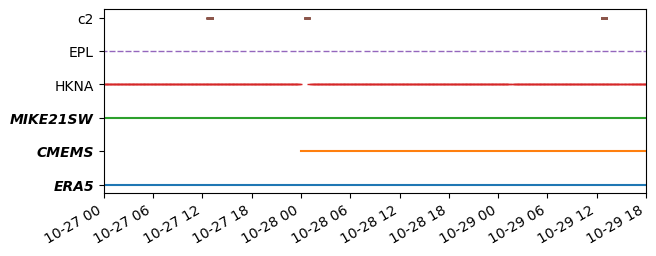

In [13]:
ms.plotting.temporal_coverage(obs=[o1,o2,o3], mod=[mrERA5, mrCMEMS, mrMIKE])

In [14]:
# o1 is slightly outside the model domain of mrERA5, 
# we therefore use "nearest" instead of the default spatial interpolation method  
cc = ms.match(
    obs=[o1, o2, o3], 
    mod=[mrERA5, mrCMEMS, mrMIKE], 
    spatial_method='nearest',
)

## Analysis and plotting
Which model is better? 

In [15]:
sk = cc.skill()
sk.swaplevel().sort_index(level="observation").style()

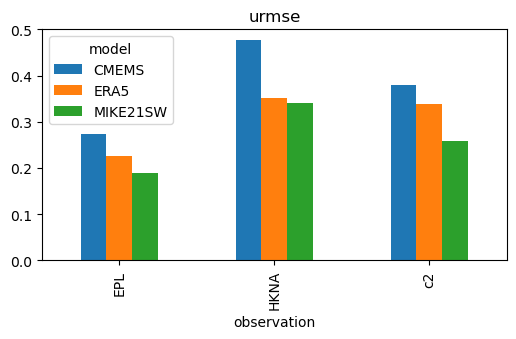

In [16]:
sk["urmse"].plot.bar(figsize=(6,3));

In [17]:
cc.mean_skill().style()

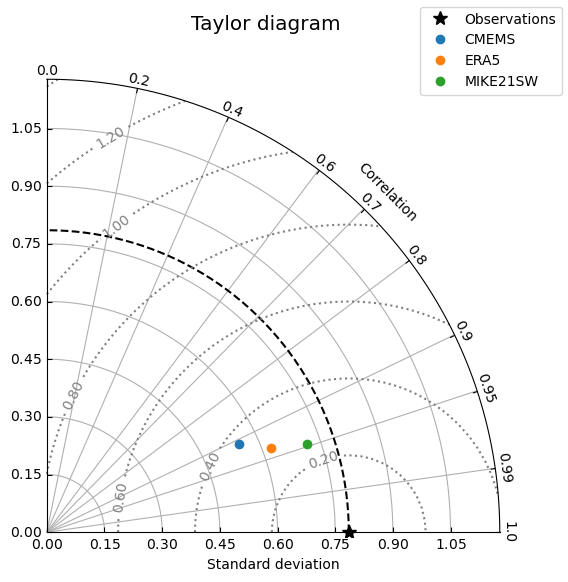

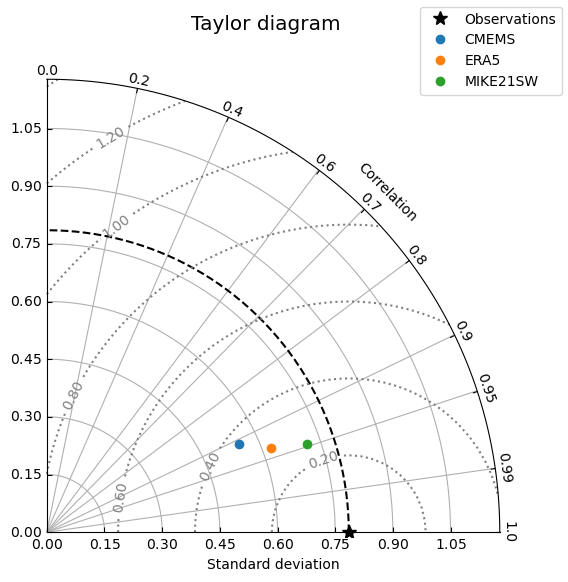

In [18]:
cc.plot.taylor(figsize=6)